Collaborators:
- **Aristarchos Kaloutsas**
- **Pavlos Ntais**

# **Prerequisites**

In [31]:
!pip install pandas
!pip install matplotlib
!pip install wordcloud
!pip install folium
!pip install scikit-learn
!pip install nltk
!pip install spacy

# **Import Libraries**

In [32]:
# part 1
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import folium
import zipfile
import re
import numpy as np


use_drive = True
if (use_drive):
    from google.colab import drive
    drive.mount('/content/drive')

# part 2
import nltk
import spacy
import spacy.cli
from sklearn.feature_extraction.text import CountVectorizer as cvect
from sklearn.feature_extraction.text import TfidfVectorizer as tfvect

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data preprocessing**

For data processing, we create the dataframes for years 2019 and 2023.

We also apply these steps:
- Remove rows containing null values only for columns that will be needed in the queries.
- Lowecase column names.

In [33]:
# modify this to use the folder where the data exists

main_directory = None
if (use_drive):
    main_directory = os.path.join(f"/content/drive/MyDrive/", 'data')
else:
    home_directory = os.path.expanduser('~')
    main_directory = os.path.join(home_directory, 'data')

def merge(year):
    folder = os.path.join(main_directory, str(year))

    dfs   = []
    dfs_r = []

    for month_folder in os.listdir(folder):
        month_folder_path = os.path.join(folder, month_folder)

        if not os.path.isdir(month_folder_path):
            continue

        reviews_name = os.path.join(month_folder_path, 'reviews.csv')
        csv_files = [file for file in os.listdir(month_folder_path) if file.endswith('listings.csv')]

        for csv_file in csv_files:
            csv_file_path = os.path.join(month_folder_path, csv_file)

            df_r = pd.read_csv(reviews_name)

            df = pd.read_csv(csv_file_path)

            df['month'] = os.path.basename(os.path.normpath(month_folder_path))

            dfs.append(df)
            dfs_r.append(df_r)


    merged_df = pd.concat(dfs, ignore_index=True)

    df_rev = pd.concat(dfs_r, ignore_index=True)

    merged_df['neighbourhood'] = merged_df['neighbourhood_cleansed']

    if year == 2019:
        filt = [
            "id"
            ,"zipcode"
            ,"transit"
            ,"Bedrooms"
            ,"Beds"
            ,"Review_scores_rating"
            ,"Number_of_reviews"
            ,"Neighbourhood"
            ,"Name"
            ,"Latitude"
            ,"Longitude"
            ,"Last_review"
            ,"Instant_bookable"
            ,"Host_since"
            ,"Host_response_rate"
            ,"Host_identity_verified"
            ,"Host_has_profile_pic"
            ,"First_review"
            ,"Description"
            ,"City"
            ,"cancellation_policy"
            ,"Bed_type"
            ,"Bathrooms"
            ,"Accommodates"
            ,"Amenities"
            ,"Room_type"
            ,"Property_type"
            ,"price"
            ,"Availability_365"
            ,"Minimum_nights"
            ,"month"
            ,"host_id"
        ]
    else:
        filt = [
            "id"
            ,"Bedrooms"
            ,"Beds"
            ,"Review_scores_rating"
            ,"Number_of_reviews"
            ,"Neighbourhood"
            ,"Name"
            ,"Latitude"
            ,"Longitude"
            ,"Last_review"
            ,"Instant_bookable"
            ,"Host_since"
            ,"Host_response_rate"
            ,"Host_identity_verified"
            ,"Host_has_profile_pic"
            ,"First_review"
            ,"Description"
            ,"Bathrooms"
            ,"Accommodates"
            ,"Amenities"
            ,"Room_type"
            ,"Property_type"
            ,"price"
            ,"Availability_365"
            ,"month"
            ,"Minimum_nights"
            ,"host_id"
        ]

    filtr = [s.lower() for s in filt]

    filtered = merged_df[filtr]

    filtNaN =  ['room_type', 'name', 'month', 'price', 'neighbourhood', 'room_type', 'description', 'last_review', 'review_scores_rating', 'host_id']
    if year == 2019:
        filtNaN.extend(['transit'])

    for f in filtNaN:
        filtered = filtered[filtered[f].notnull()]

    if year == 2019:
        filtered['zipcode'] = filtered['zipcode'].str.replace('\s+', '', regex=True)

    filtered["price"] = filtered["price"].replace("[$,]", "", regex=True).astype(float)

    filtered = filtered[filtered['price'] < 10000]

    filtered = filtered[filtered['price'] > 0]

    filtered = filtered[filtered['id'] < 1000000000]

    filtered['last_review'] = pd.to_datetime(filtered['last_review'], errors='coerce')

    int_cols = ['bedrooms', 'beds']
    if year == 2019:
        int_cols.extend(['id', 'zipcode'])

    for col in int_cols:
        filtered[col] = pd.to_numeric(filtered[col], errors='coerce', downcast='integer')

    df_rev = df_rev[df_rev['comments'].notnull()]

    return filtered, df_rev

In [34]:
# get the dataframes
m2019, r2019 = merge(2019)
m2023, r2023 = merge(2023)

<ipython-input-33-4ff9a1a84d2e>:30: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
<ipython-input-33-4ff9a1a84d2e>:30: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)
<ipython-input-33-4ff9a1a84d2e>:30: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


# **Queries**

### **Query 1**
What is the most common type of room in your data (room_type)?

In [35]:
def query1(df, year):
    print(f'Most common room type for {year}:', df['room_type'].value_counts().idxmax())

query1(m2019, 2019)
query1(m2023, 2023)

Most common room type for 2019: Entire home/apt
Most common room type for 2023: Entire home/apt


### **Query 2**
Create a graph or graphs showing the price trends over a 3-month period

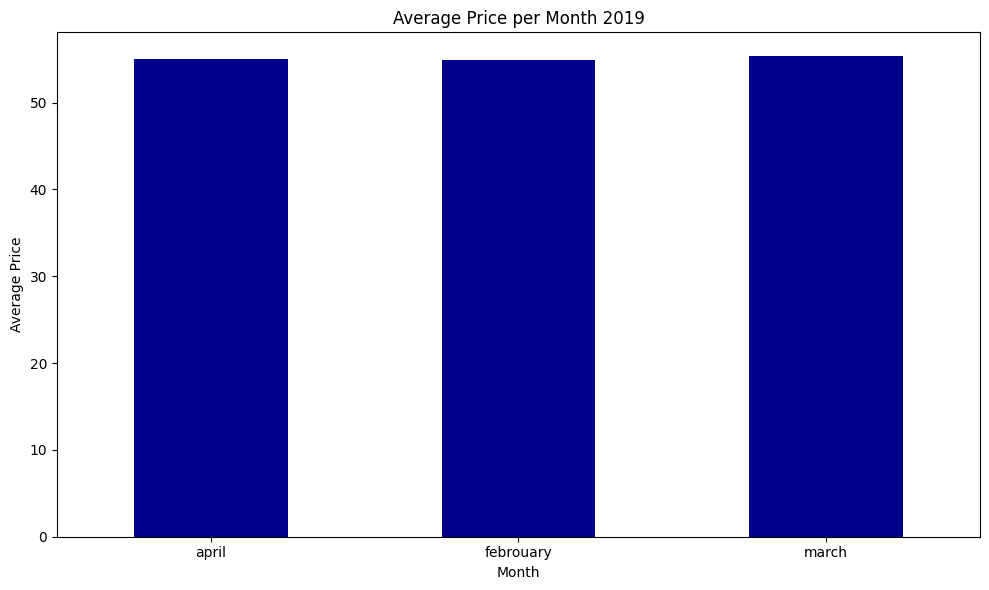

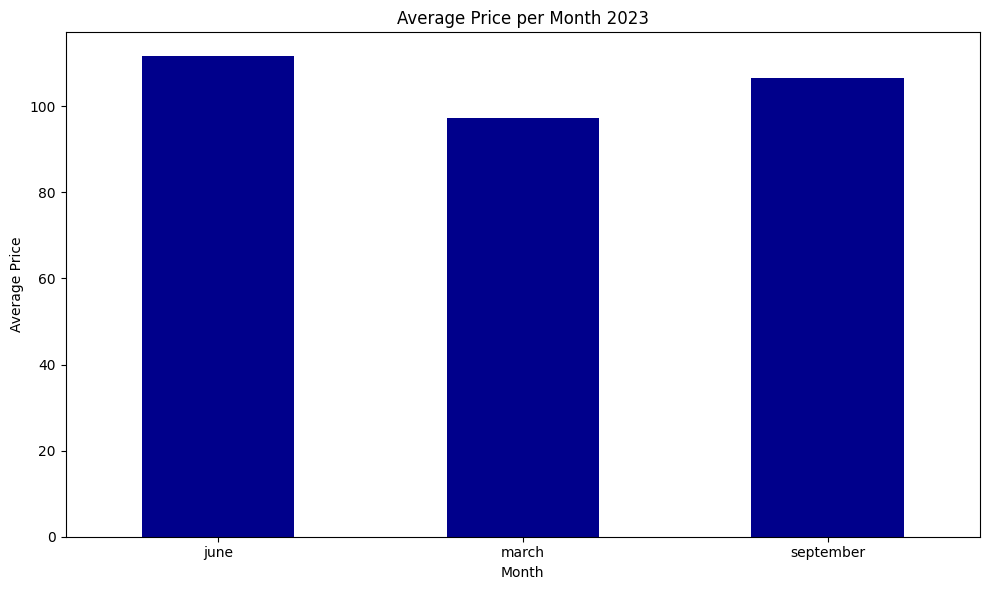

In [36]:
def query2(df, year):
    avg_per_month = df.groupby('month')['price'].mean()

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    avg_per_month.plot(kind='bar', color='darkblue')
    plt.title(f'Average Price per Month {year}')
    plt.xlabel('Month')
    plt.ylabel('Average Price')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

query2(m2019, 2019)
query2(m2023, 2023)

### **Query 3**
Which are the top 5 neighborhoods with the most reviews?

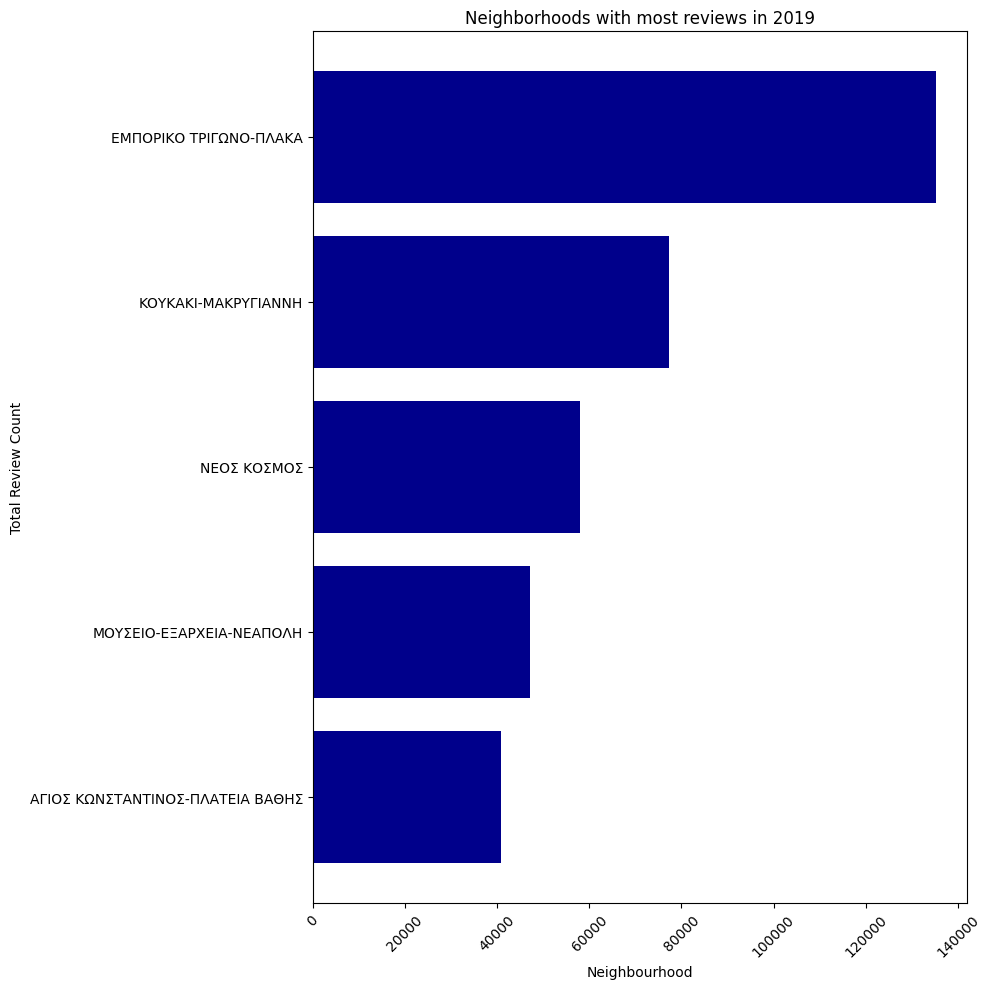

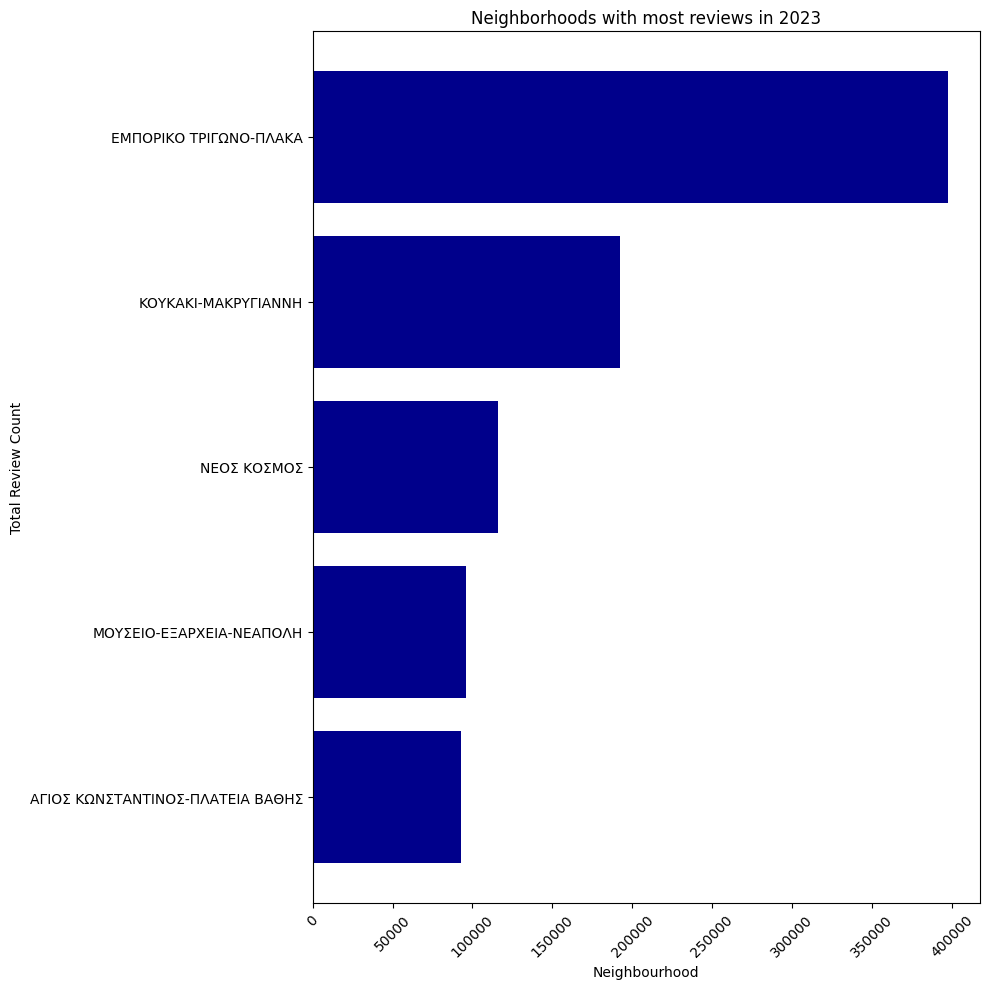

In [37]:
def query3(df, year):
    review_counts = df.groupby('neighbourhood')['number_of_reviews'].sum().reset_index()

    top_neighborhoods = review_counts.sort_values(by='number_of_reviews', ascending=True).tail(5)

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.barh(top_neighborhoods['neighbourhood'], top_neighborhoods['number_of_reviews'], color='darkblue')

    ax.set_xlabel('Neighbourhood')
    ax.set_ylabel('Total Review Count')
    ax.set_title(f'Neighborhoods with most reviews in {year}')
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

query3(m2019, 2019)
query3(m2023, 2023)

### **Query 4**
Which neighborhood has the most property listings?

In [38]:
def query4(df, year):
    counts = df.groupby('neighbourhood').size()
    print(f"The neighborhood with the most apparentment listings in {year} is: {counts.idxmax()}")

query4(m2019, 2019)
query4(m2023, 2023)

The neighborhood with the most apparentment listings in 2019 is: ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ
The neighborhood with the most apparentment listings in 2023 is: ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ


### **Query 5**
How many listings are there per neighborhood and per month?

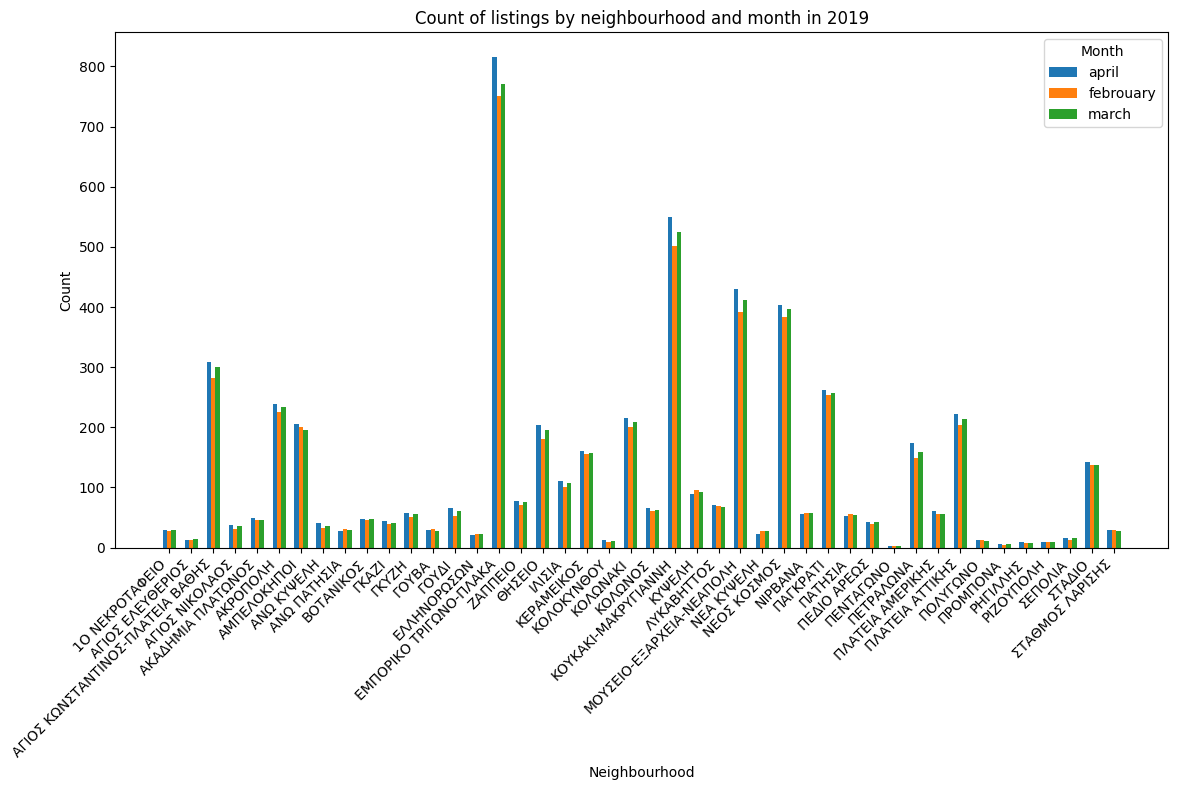

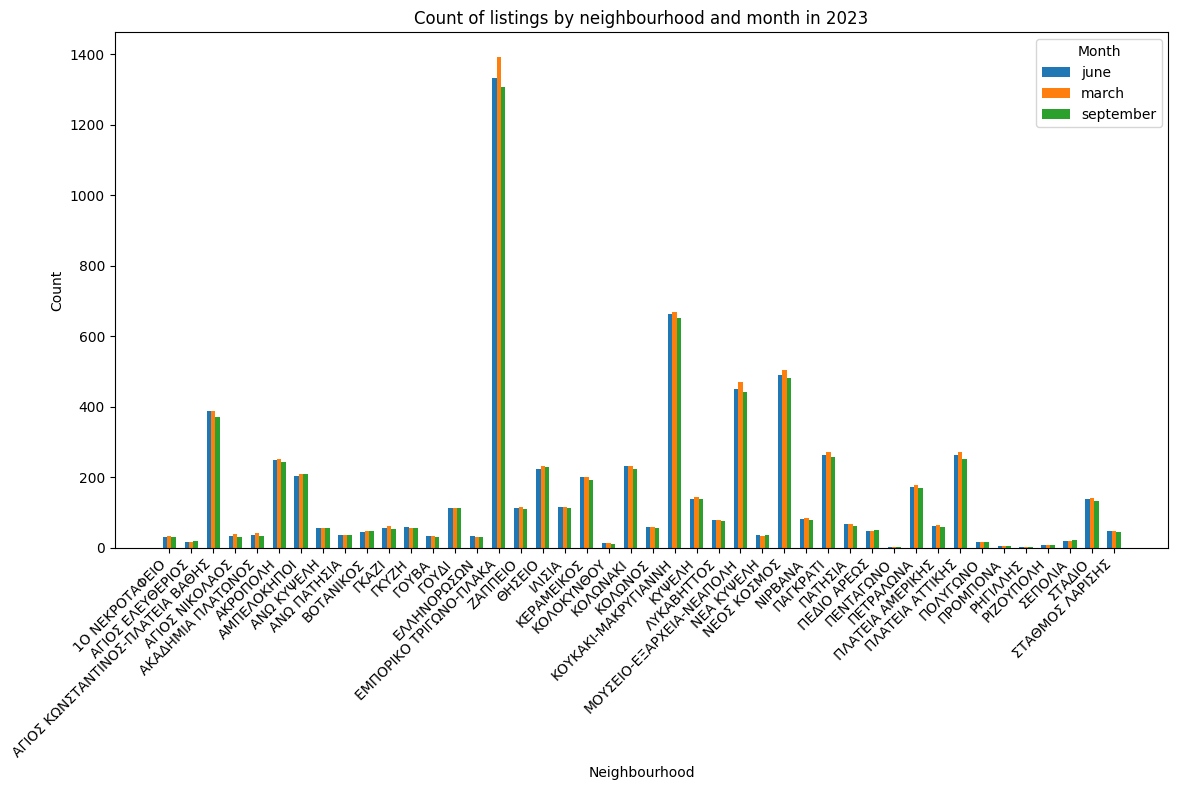

In [39]:
def query5(df, year):
    counts = df.groupby(['neighbourhood', 'month']).size().unstack(fill_value=0)

    months = counts.columns

    fig, ax = plt.subplots(figsize=(12, 8))

    bar_width = 0.2

    x = np.arange(len(counts.index))

    for i, month in enumerate(months):
        ax.bar(x + i * bar_width, counts[month], width=bar_width, label=month)

    ax.set_xlabel('Neighbourhood')
    ax.set_ylabel('Count')
    ax.set_title(f'Count of listings by neighbourhood and month in {year}')
    ax.set_xticks(x + (len(months) - 1) * bar_width / 2)
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.legend(title='Month')

    plt.tight_layout()
    plt.show()

query5(m2019, 2019)
query5(m2023, 2023)

### **Query 6**
Draw a histogram of the neighborhood variable

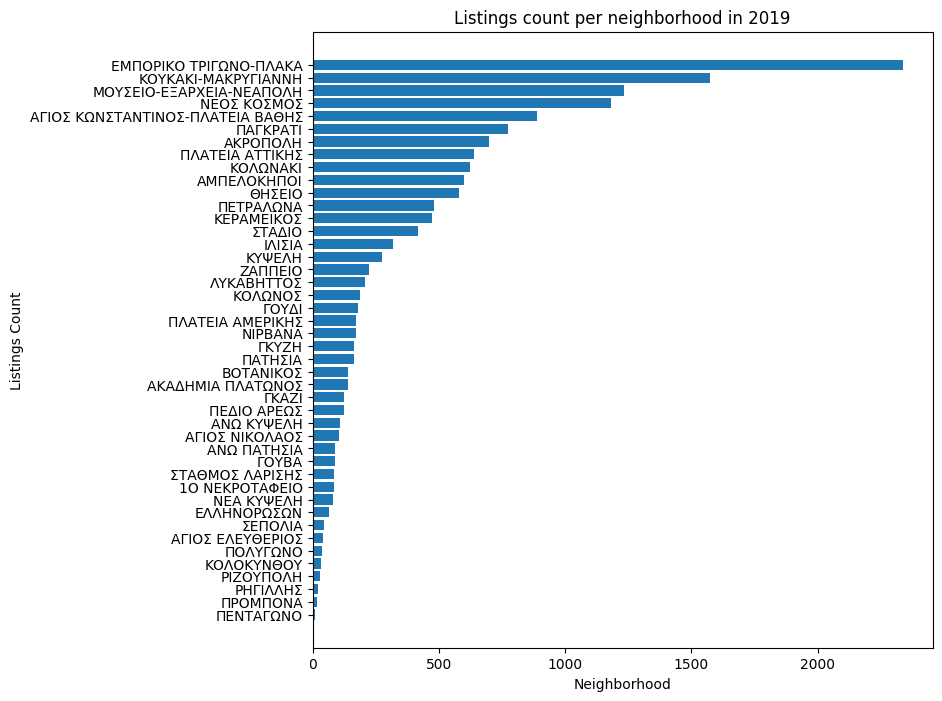

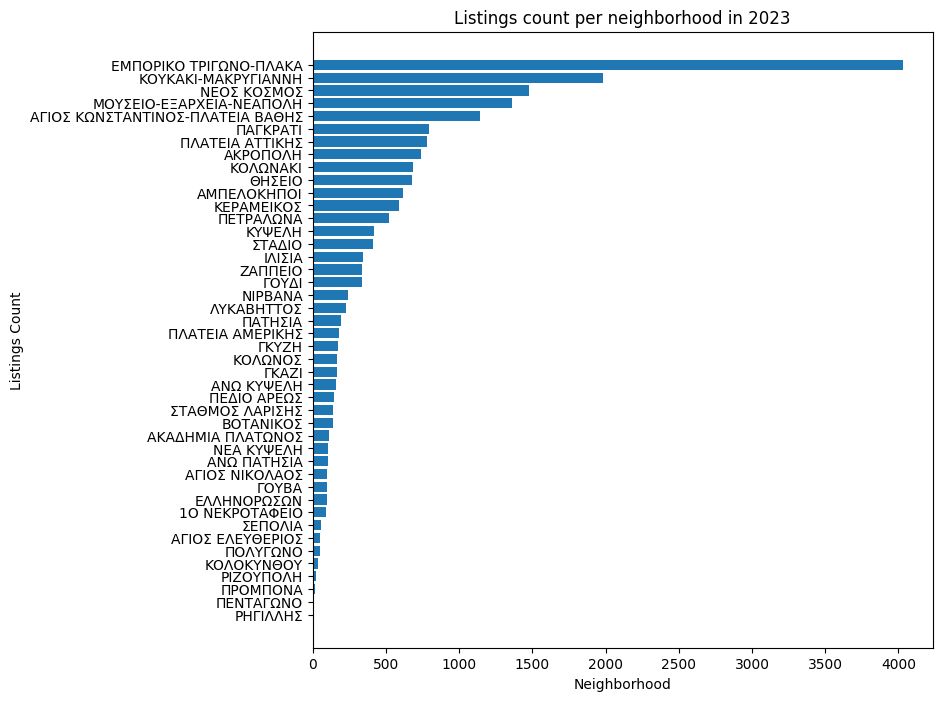

In [40]:
def query6(df, year):
    counts = df['neighbourhood'].value_counts().sort_values()
    plt.figure(figsize=(8, 8))
    plt.barh(counts.index, counts.values)
    plt.xlabel('Neighborhood')
    plt.ylabel('Listings Count')
    plt.title(f'Listings count per neighborhood in {year}')
    plt.show()

query6(m2019, 2019)
query6(m2023, 2023)

### **Query 7**
What is the most common room type (room_type) in each neighborhood?

In [41]:
def query7(df, year):
    most_common = df.groupby('neighbourhood')['room_type'].apply(lambda x: x.mode().iloc[0])

    print(f"The most common type of room per neighbourhood in {year} are:")
    print(most_common)

query7(m2019, 2019)
query7(m2023, 2023)

The most common type of room per neighbourhood in 2019 are:
neighbourhood
1Ο ΝΕΚΡΟΤΑΦΕΙΟ                      Entire home/apt
ΑΓΙΟΣ ΕΛΕΥΘΕΡΙΟΣ                    Entire home/apt
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ    Entire home/apt
ΑΓΙΟΣ ΝΙΚΟΛΑΟΣ                      Entire home/apt
ΑΚΑΔΗΜΙΑ ΠΛΑΤΩΝΟΣ                   Entire home/apt
ΑΚΡΟΠΟΛΗ                            Entire home/apt
ΑΜΠΕΛΟΚΗΠΟΙ                         Entire home/apt
ΑΝΩ ΚΥΨΕΛΗ                          Entire home/apt
ΑΝΩ ΠΑΤΗΣΙΑ                         Entire home/apt
ΒΟΤΑΝΙΚΟΣ                           Entire home/apt
ΓΚΑΖΙ                               Entire home/apt
ΓΚΥΖΗ                               Entire home/apt
ΓΟΥΒΑ                               Entire home/apt
ΓΟΥΔΙ                               Entire home/apt
ΕΛΛΗΝΟΡΩΣΩΝ                         Entire home/apt
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ              Entire home/apt
ΖΑΠΠΕΙΟ                             Entire home/apt
ΘΗΣΕΙΟ                              Entire

### **Query 8**
What is the most expensive room type?

In [42]:
def query8(df, year):
    largest_price = df.loc[df['price'].idxmax()]

    print(f"Most expensive room type in {year}:", largest_price['room_type'])

    means = df.groupby('room_type')['price'].mean()

    largest_mean = means.idxmax()
    print(f"Room type with most expensive mean in {year}:", largest_mean)

query8(m2019, 2019)
print()
query8(m2023, 2023)

Most expensive room type in 2019: Entire home/apt
Room type with most expensive mean in 2019: Entire home/apt

Most expensive room type in 2023: Entire home/apt
Room type with most expensive mean in 2023: Hotel room


### **Query 9**
Use the Folium Map library to display properties on a map for a selected month, and show additional information (e.g., bed_type, room_type, transit) in the popups

In [43]:
def query9(df, month):
    samples = df[df['month'] == month].sample(n=300)

    m = folium.Map(location=[samples['latitude'].mean(), samples['longitude'].mean()], zoom_start=12)

    for _, row in samples.iterrows():
        folium.Marker([row['latitude'], row['longitude']], popup=row['room_type']).add_to(m)

    display(m)

query9(m2019, 'march')
query9(m2023, 'march')

### **Query 10**
Create different word clouds using the data from the columns: neighbourhood, transit, description, and last_review

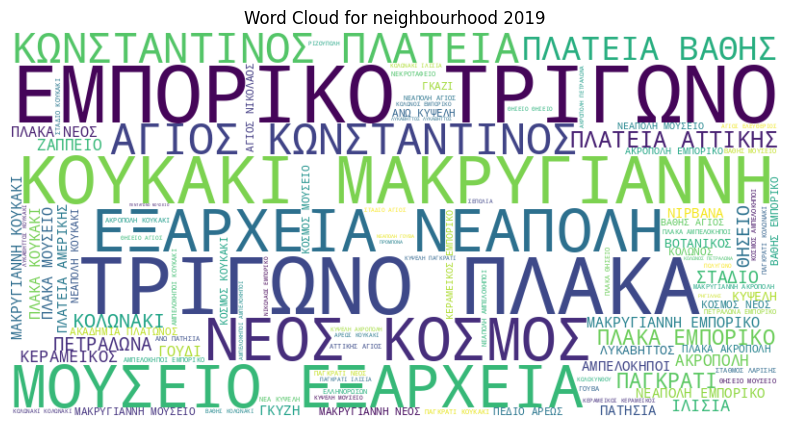

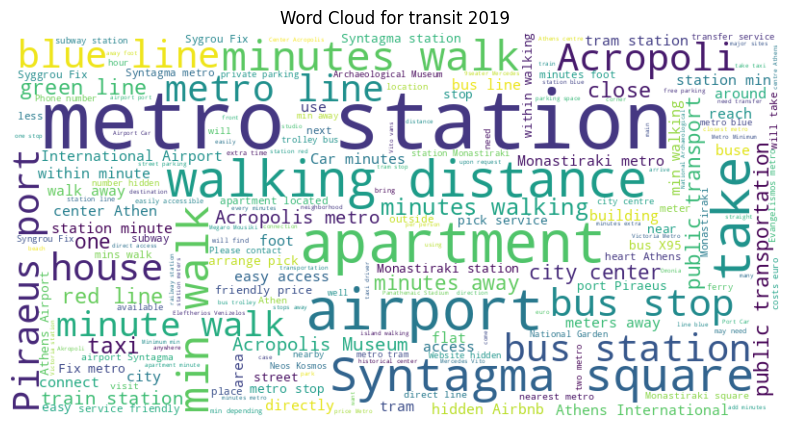

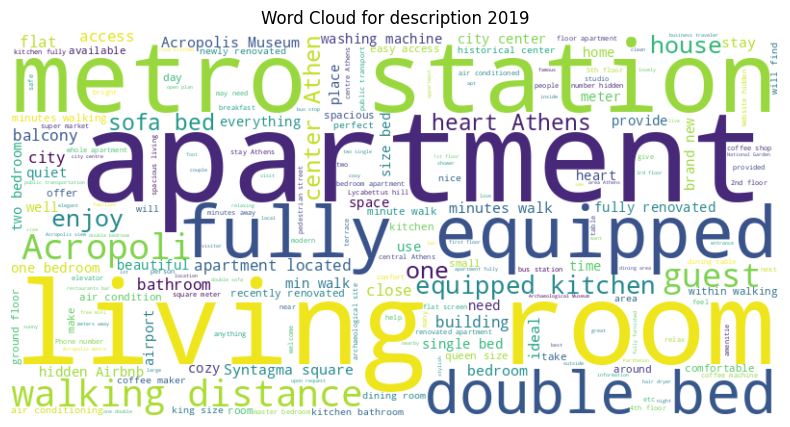

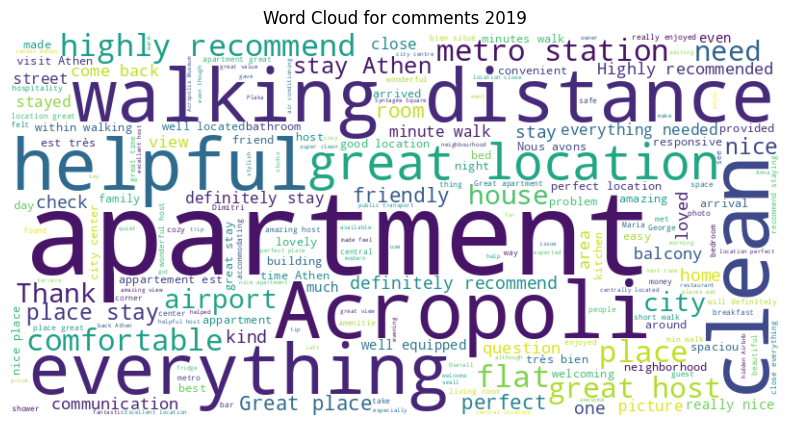

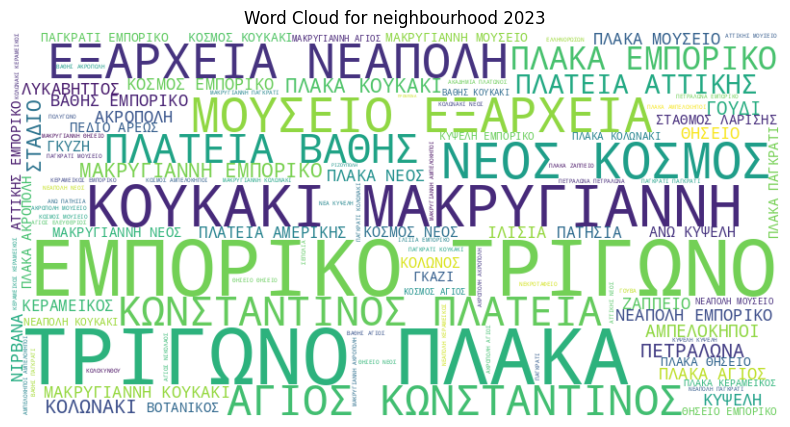

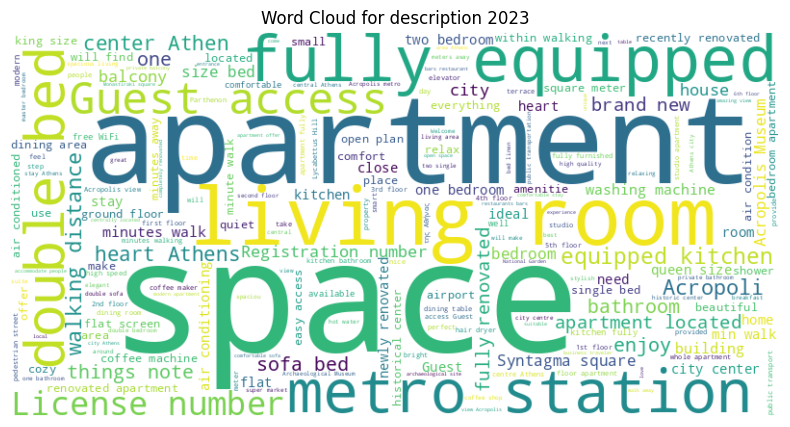

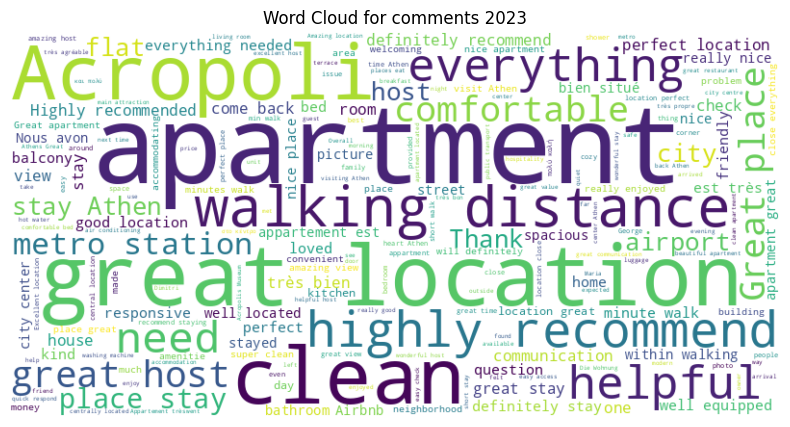

In [44]:
def query10(df, df_r, year, cols):
    # reg expression to remove special characters and words less than 2 chars
    pattern1 = r'/[^a-zA-Z ]/g'
    pattern2 = r'\b\w{1,2}\b'

    for column in cols:
        text = ' '.join(df[column])
        text = re.sub(pattern1, ' ', text)
        text = re.sub(pattern2, ' ', text)

        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {column} {year}')
        plt.axis('off')
        plt.show()

    # select 50% of data for comments
    text = ' '.join(df_r['comments'].sample(frac=0.5))
    text = re.sub(pattern1, ' ', text)
    text = re.sub(pattern2, ' ', text)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for comments {year}')
    plt.axis('off')
    plt.show()

query10(m2019, r2019, 2019, ['neighbourhood', 'transit', 'description'])
query10(m2023, r2023, 2023, ['neighbourhood', 'description'])

### **Query 11**
Simplify the values in the "amenities" column by grouping similar items into categories like "kitchen," "accessibility," or "technology". After simplifying, create a histogram showing the distribution of these new categories

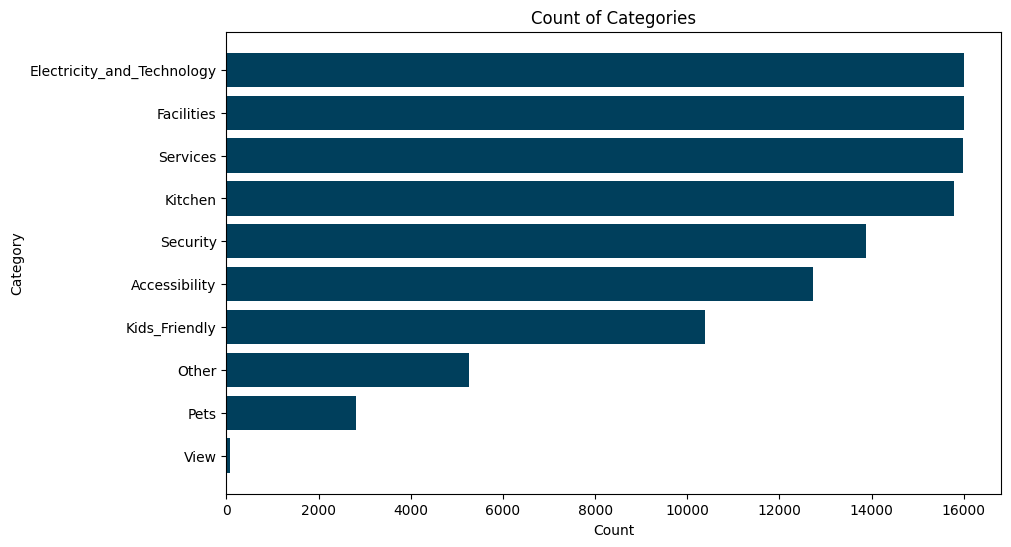

In [45]:
split_strings = m2019['amenities'].str.split(',')

split_strings = split_strings.apply(lambda x: [re.sub(r'\W+', '', item.strip()) for item in x])

# Flatten the list of elements
flattened_list = [item.strip() for sublist in split_strings for item in sublist]

# Convert the flattened list into a pandas Series
unique_series = pd.Series(flattened_list)

# Extract unique values
unique_values = unique_series.unique()

amenities_categories = {
    'TV': 'Electricity_and_Technology',
    'CableTV': 'Electricity_and_Technology',
    'Internet': 'Electricity_and_Technology',
    'Wifi': 'Electricity_and_Technology',
    'Airconditioning': 'Electricity_and_Technology',
    'Kitchen': 'Kitchen',
    'Elevator': 'Accessibility',
    'Buzzerwirelessintercom': 'Security',
    'Heating': 'Electricity_and_Technology',
    'Familykidfriendly': 'Kids_Friendly',
    'Washer': 'Facilities',
    'Dryer': 'Facilities',
    'Firstaidkit': 'Security',
    'Safetycard': 'Security',
    'Fireextinguisher': 'Security',
    'Essentials': 'Services',
    'Shampoo': 'Facilities',
    '24hourcheckin': 'Services',
    'Hangers': 'Facilities',
    'Hairdryer': 'Facilities',
    'Iron': 'Facilities',
    'Laptopfriendlyworkspace': 'Electricity_and_Technology',
    'Hotwater': 'Electricity_and_Technology',
    'Bedlinens': 'Facilities',
    'Extrapillowsandblankets': 'Facilities',
    'Ethernetconnection': 'Electricity_and_Technology',
    'Microwave': 'Kitchen',
    'Coffeemaker': 'Kitchen',
    'Refrigerator': 'Kitchen',
    'Dishwasher': 'Kitchen',
    'Dishesandsilverware': 'Facilities',
    'Cookingbasics': 'Kitchen',
    'Oven': 'Kitchen',
    'Stove': 'Kitchen',
    'Patioorbalcony': 'Facilities',
    'Luggagedropoffallowed': 'Services',
    'Hostgreetsyou': 'Services',
    'Highchair': 'Kids_Friendly',
    'PacknPlaytravelcrib': 'Kids_Friendly',
    'Bathtub': 'Facilities',
    'Longtermstaysallowed': 'Services',
    'Smokedetector': 'Security',
    'Carbonmonoxidedetector': 'Security',
    'Paidparkingoffpremises': 'Services',
    'Roomdarkeningshades': 'Facilities',
    'Widedoorway': 'Accessibility',
    'Stepfreeaccess': 'Accessibility',
    'Wideclearancetobed': 'Accessibility',
    'Breakfast': 'Kitchen',
    'Freestreetparking': 'Services',
    'Pocketwifi': 'Electricity_and_Technology',
    'Cleaningbeforecheckout': 'Services',
    'Accessibleheightbed': 'Accessibility',
    'Other': 'Other',
    'Handheldshowerhead': 'Facilities',
    'Indoorfireplace': 'Facilities',
    'Privatelivingroom': 'Facilities',
    'Singlelevelhome': 'Accessibility',
    'Widehallwayclearance': 'Accessibility',
    'Flatpathtofrontdoor': 'Accessibility',
    'Wideentryway': 'Accessibility',
    'Lockonbedroomdoor': 'Security',
    'translationmissingenhosting_amenity_49': 'Other',
    'translationmissingenhosting_amenity_50': 'Other',
    'Selfcheckin': 'Services',
    'Lockbox': 'Security',
    'Childrensbooksandtoys': 'Kids_Friendly',
    'Crib': 'Kids_Friendly',
    'Smokingallowed': 'Other',
    'Petsallowed': 'Pets',
    'Hottub': 'Facilities',
    'Welllitpathtoentrance': 'Accessibility',
    'Accessibleheighttoilet': 'Accessibility',
    'Wideclearancetoshower': 'Accessibility',
    'toilet': 'Facilities',
    'Gameconsole': 'Electricity_and_Technology',
    'Fullkitchen': 'Kitchen',
    'Paidparkingonpremises': 'Services',
    'Wheelchairaccessible': 'Accessibility',
    'Buildingstaff': 'Services',
    'Freeparkingonpremises': 'Services',
    'Petsliveonthisproperty': 'Other',
    'Cats': 'Pets',
    'Privateentrance': 'Security',
    'BBQgrill': 'Kitchen',
    'Gardenorbackyard': 'Facilities',
    'Suitableforevents': 'Other',
    'Windowguards': 'Security',
    'Childrensdinnerware': 'Kids_Friendly',
    'Bodysoap': 'Facilities',
    'Bathtowel': 'Facilities',
    'Toiletpaper': 'Facilities',
    'DVDplayer': 'Electricity_and_Technology',
    'Firepit': 'Facilities',
    'Convectionoven': 'Kitchen',
    'Walkinshower': 'Facilities',
    'Bedroomcomforts': 'Facilities',
    'Bathroomessentials': 'Facilities',
    'Beachessentials': 'Facilities',
    'Doorman': 'Security',
    'Outletcovers': 'Kids_Friendly',
    'Changingtable': 'Facilities',
    'Babybath': 'Facilities',
    'Dogs': 'Pets',
    'Firmmattress': 'Facilities',
    'EVcharger': 'Electricity_and_Technology',
    'Fixedgrabbarsforshower': 'Accessibility',
    'Babysitterrecommendations': 'Kids_Friendly',
    'Hotwaterkettle': 'Kitchen',
    'Minifridge': 'Kitchen',
    'Rainshower': 'Facilities',
    'Terrace': 'Facilities',
    'Balcony': 'Facilities',
    'Breakfasttable': 'Facilities',
    'Espressomachine': 'Kitchen',
    'Formaldiningarea': 'Facilities',
    'Doubleoven': 'Kitchen',
    'Memoryfoammattress': 'Facilities',
    'Murphybed': 'Facilities',
    'Outdoorseating': 'Facilities',
    'Keypad': 'Security',
    'Bathtubwithbathchair': 'Accessibility',
    'Rollinshower': 'Accessibility',
    'Kitchenette': 'Facilities',
    'Showerchair': 'Accessibility',
    'Tablecornerguards': 'Kids_Friendly',
    'Smartlock': 'Security',
    'Stairgates': 'Kids_Friendly',
    'Disabledparkingspot': 'Accessibility',
    'Fixedgrabbarsfortoilet': 'Accessibility',
    'Fireplaceguards': 'Security',
    'Gym': 'Facilities',
    'Soakingtub': 'Facilities',
    'Babymonitor': 'Facilities',
    'SmartTV': 'Electricity_and_Technology',
    'Soundsystem': 'Electricity_and_Technology',
    'Highresolutioncomputermonitor': 'Electricity_and_Technology',
    'Ensuitebathroom': 'Facilities',
    'Mountainview': 'View',
    'Exerciseequipment': 'Facilities',
    'Pillowtopmattress': 'Facilities',
    'Pool': 'Facilities',
    'Ceilingfan': 'Facilities',
    'Heatedtowelrack': 'Facilities',
    'SkiinSkiout': 'Other',
    'Bidet': 'Facilities',
    'Printer': 'Electricity_and_Technology',
    'Netflix': 'Services',
    'Faxmachine': 'Electricity_and_Technology',
    'Winecooler': 'Kitchen',
    'Mudroom': 'Facilities',
    'Beachfront': 'View',
    'Centralairconditioning': 'Electricity_and_Technology',
    'Daybed': 'Facilities',
    'Standingvalet': 'Facilities',
    'Outdoorparking': 'Facilities',
    'Groundflooraccess': 'Accessibility',
    'Steamoven': 'Kitchen',
    'Otherpets': 'Pets',
    'Waterfront': 'Other',
    'Heatedfloors': 'Facilities',
    'Gasoven': 'Kitchen',
    'Electricprofilingbed': 'Facilities',
    'Standalonesteamshower': 'Facilities',
    'Projectorandscreen': 'Electricity_and_Technology',
    'Airpurifier': 'Facilities',
    'Sharedgym': 'Facilities',
    'Sunloungers': 'Facilities',
    'AmazonEcho': 'Electricity_and_Technology',
    'Touchlessfaucets': 'Facilities',
    'Jettedtub': 'Facilities',
    'Beachview': 'View',
    'Alfrescobathtub': 'Facilities',
    'Privatehottub': 'Facilities',
    'Warmingdrawer': 'Facilities',
    'Hammock': 'Facilities',
    'Privatepool': 'Facilities',
    'Sauna': 'Facilities',
    'Heatlamps': 'Facilities',
    'IroningBoard': 'Facilities',
    'Freezer': 'Kitchen',
    'HBOGO': 'Services',
    'Lakeaccess': 'Other'
}

inverse_amenities_categories = {}
for k, v in amenities_categories.items():
    inverse_amenities_categories[v] = inverse_amenities_categories.get(v, []) + [k]

counts = {key: len(value) for key, value in inverse_amenities_categories.items()}

def turn_to_category(s):
    s = s.split(',')
    l = [re.sub(r'\W+', '', item.strip()) for item in s]

    r = [amenities_categories[item] for item in l]

    return list(set(r))

df = m2019['amenities'].to_frame()
df['amenities'] = df['amenities'].apply(turn_to_category)

counts_df = pd.DataFrame(df['amenities'].explode().value_counts()).reset_index()

counts_df.columns = ['category', 'count']

counts_df = counts_df.sort_values(by='count')

plt.figure(figsize=(10, 6))
plt.barh(counts_df['category'], counts_df['count'], color='#003f5c')
plt.ylabel('Category')
plt.xlabel('Count')
plt.title('Count of Categories')
plt.show()

### **Query 12**
What is the average price per neighborhood for rooms that allow two guests? Create a graph showing neighborhoods sorted by their average price, and classify them into three groups:
- very expensive
- moderate
- affordable.

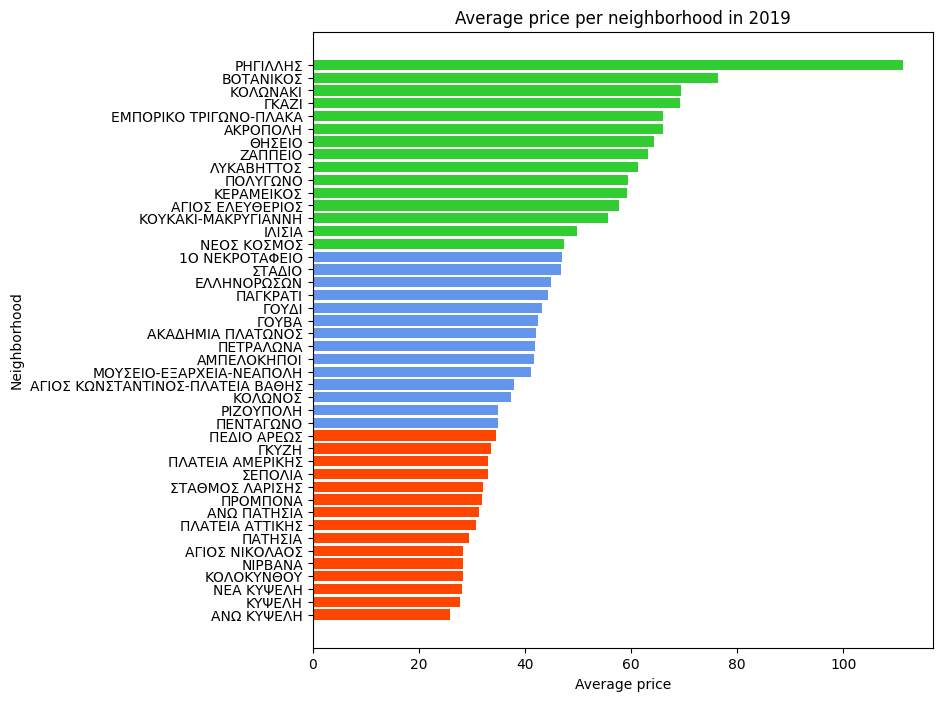

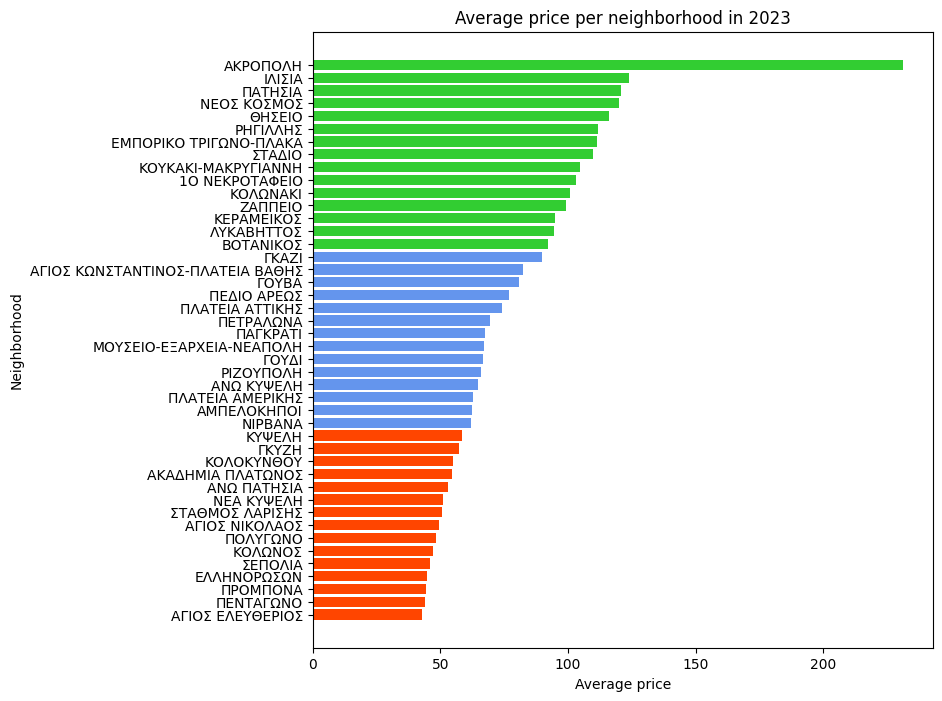

In [46]:
def query12(df, year):
    df = df[df['beds'] == 2]
    df = df.groupby('neighbourhood')['price'].mean().reset_index(name ='avg_price')
    df = df.sort_values(by=['avg_price'])

    low = df['avg_price'].quantile(0.33)
    high = df['avg_price'].quantile(0.66)

    def category(price):
        if(price <= low):
            return 'low'
        if(price <= high):
            return 'mid'
        return 'high'

    df['category'] = df['avg_price'].apply(category)

    colors = {'low': 'orangered',  'mid': 'cornflowerblue', 'high': 'limegreen'}

    plt.figure(figsize=(8, 8))
    plt.barh(df['neighbourhood'], df['avg_price'], color=[colors[cat] for cat in df['category']])

    plt.title(f'Average price per neighborhood in {year}')
    plt.xlabel('Average price')
    plt.ylabel('Neighborhood')

    # Show plot
    plt.show()

query12(m2019, 2019)
query12(m2023, 2023)

### **Query 13**

What other information could you extract from the given data?

#### **Query 13.1**: Most popular price range
In this query, we explore the most popular listings per price range. We consider these prices ranges:
- Low
- Average
- High

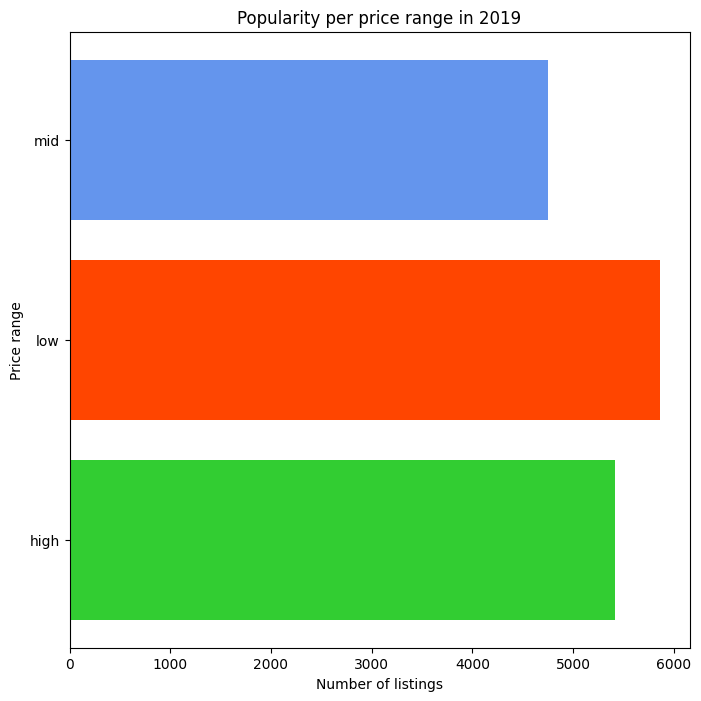

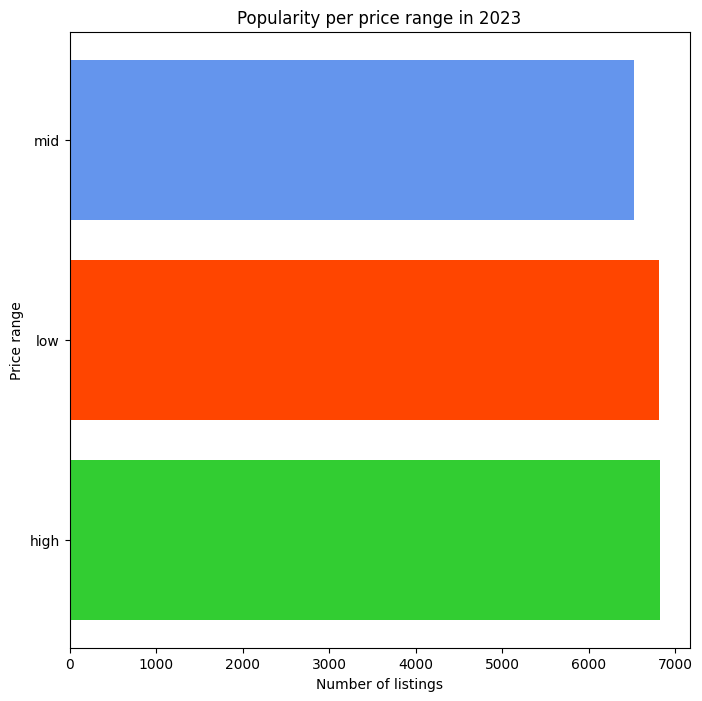

In [47]:
def query13_1(df, year):
    df = df['price'].to_frame()

    df = df.sort_values(by='price')

    low = df['price'].quantile(0.33)
    high = df['price'].quantile(0.66)

    def category(price):
        if(price <= low):
            return 'low'
        if(price <= high):
            return 'mid'
        return 'high'

    df['category'] = df['price'].apply(category)

    colors = {'low': 'orangered',  'mid': 'cornflowerblue', 'high': 'limegreen'}

    df = df.groupby('category').size().reset_index(name='count')

    plt.figure(figsize=(8, 8))
    plt.barh(df['category'], df['count'], color=[colors[cat] for cat in df['category']])

    plt.title(f'Popularity per price range in {year}')
    plt.xlabel('Number of listings')
    plt.ylabel('Price range')

    plt.show()

query13_1(m2019, 2019)
query13_1(m2023, 2023)

#### **Query 13.2**: Mean price by Property Type
In this query, we can see the average price per property type is.

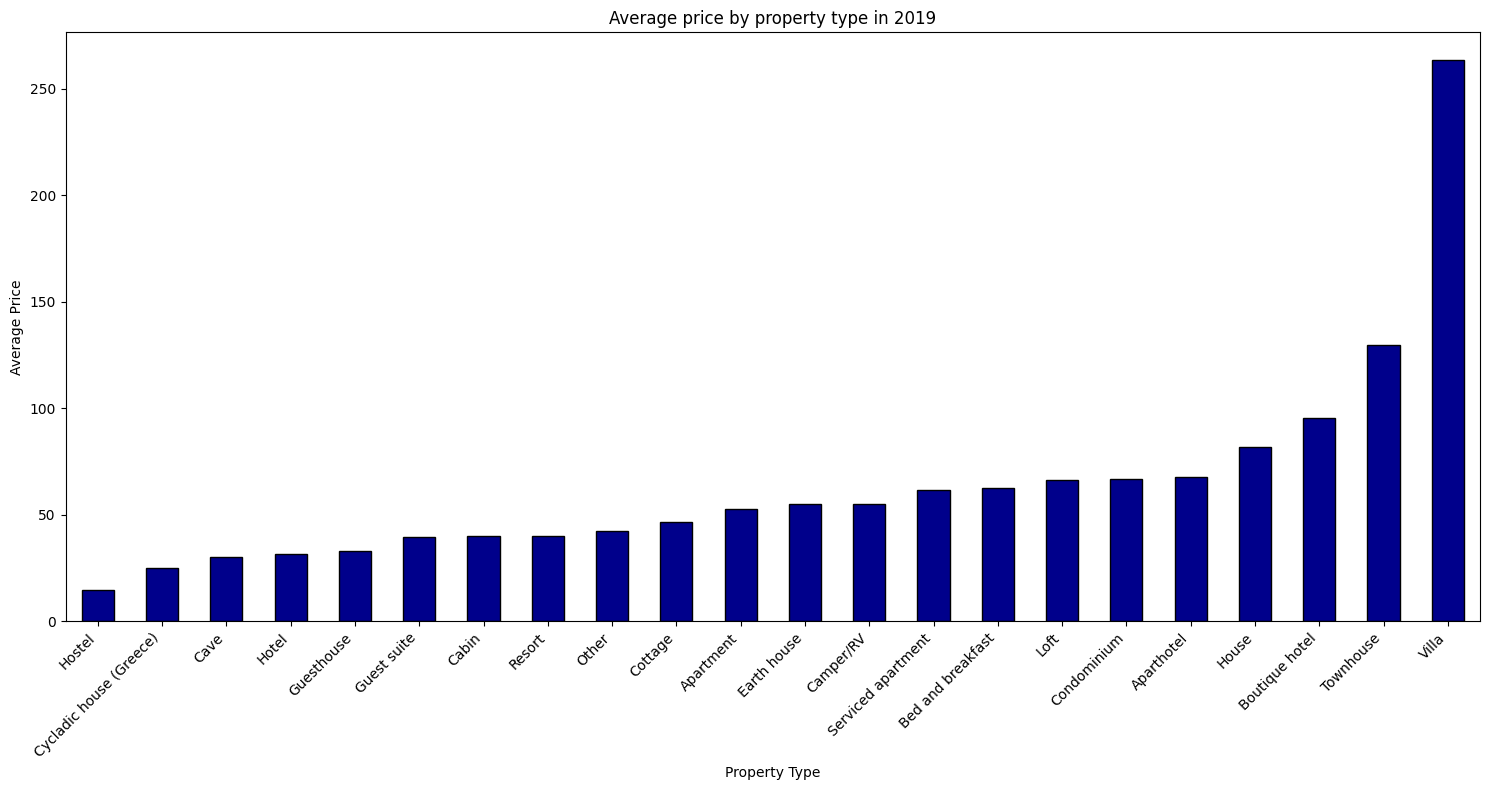

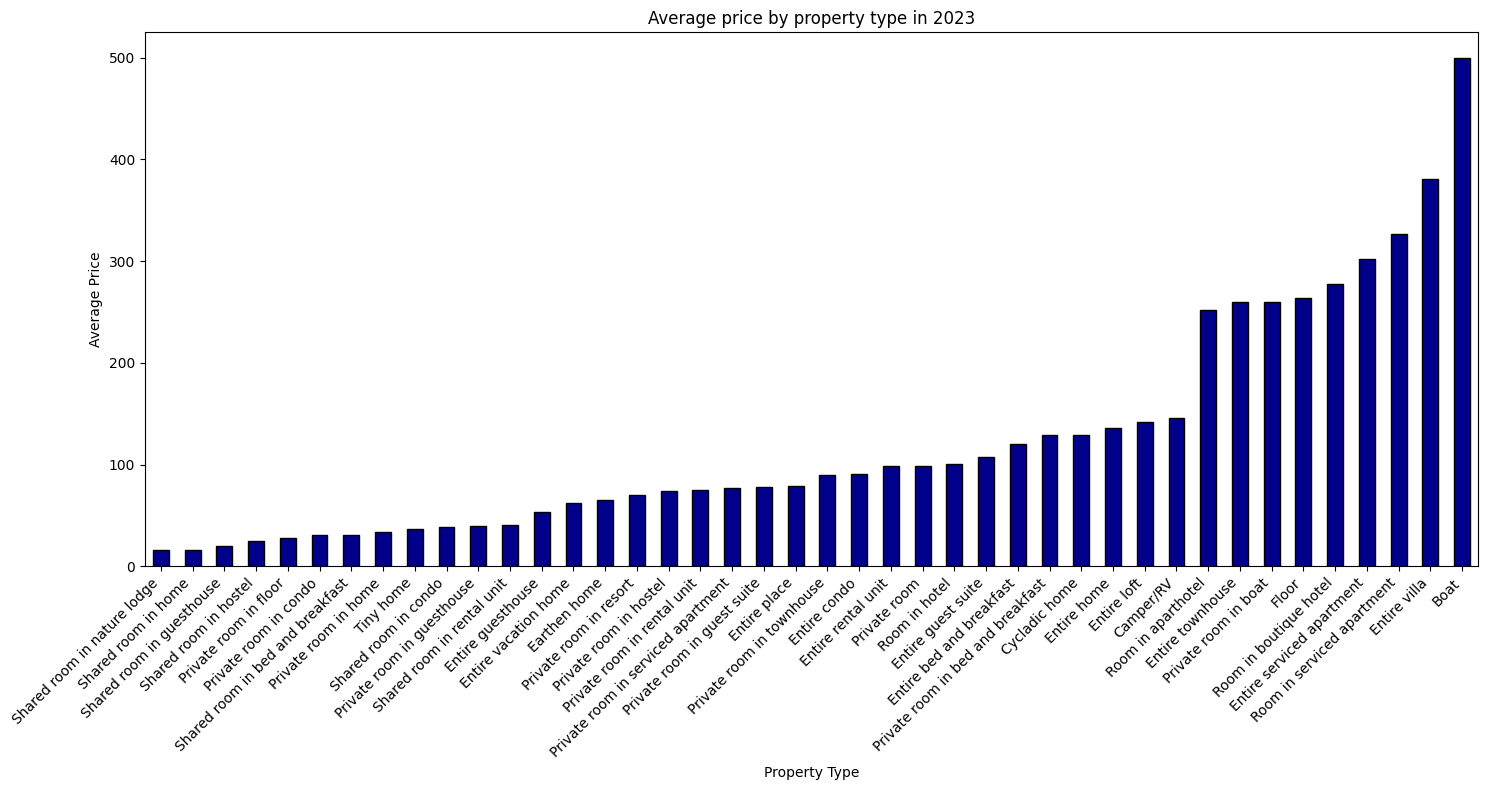

In [48]:
def query13_2(df, year):
    prices = df.groupby('property_type')['price'].mean().sort_values()

    plt.figure(figsize=(15, 8))
    prices.plot(kind='bar', color='darkblue', edgecolor='black')
    plt.xlabel('Property Type')
    plt.ylabel('Average Price')
    plt.title(f'Average price by property type in {year}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

query13_2(m2019, 2019)
query13_2(m2023, 2023)

#### **Query 13.3**: Property type distribution by neighbourhood
In this query, we visualize the property type distribution (by neighbourhood).


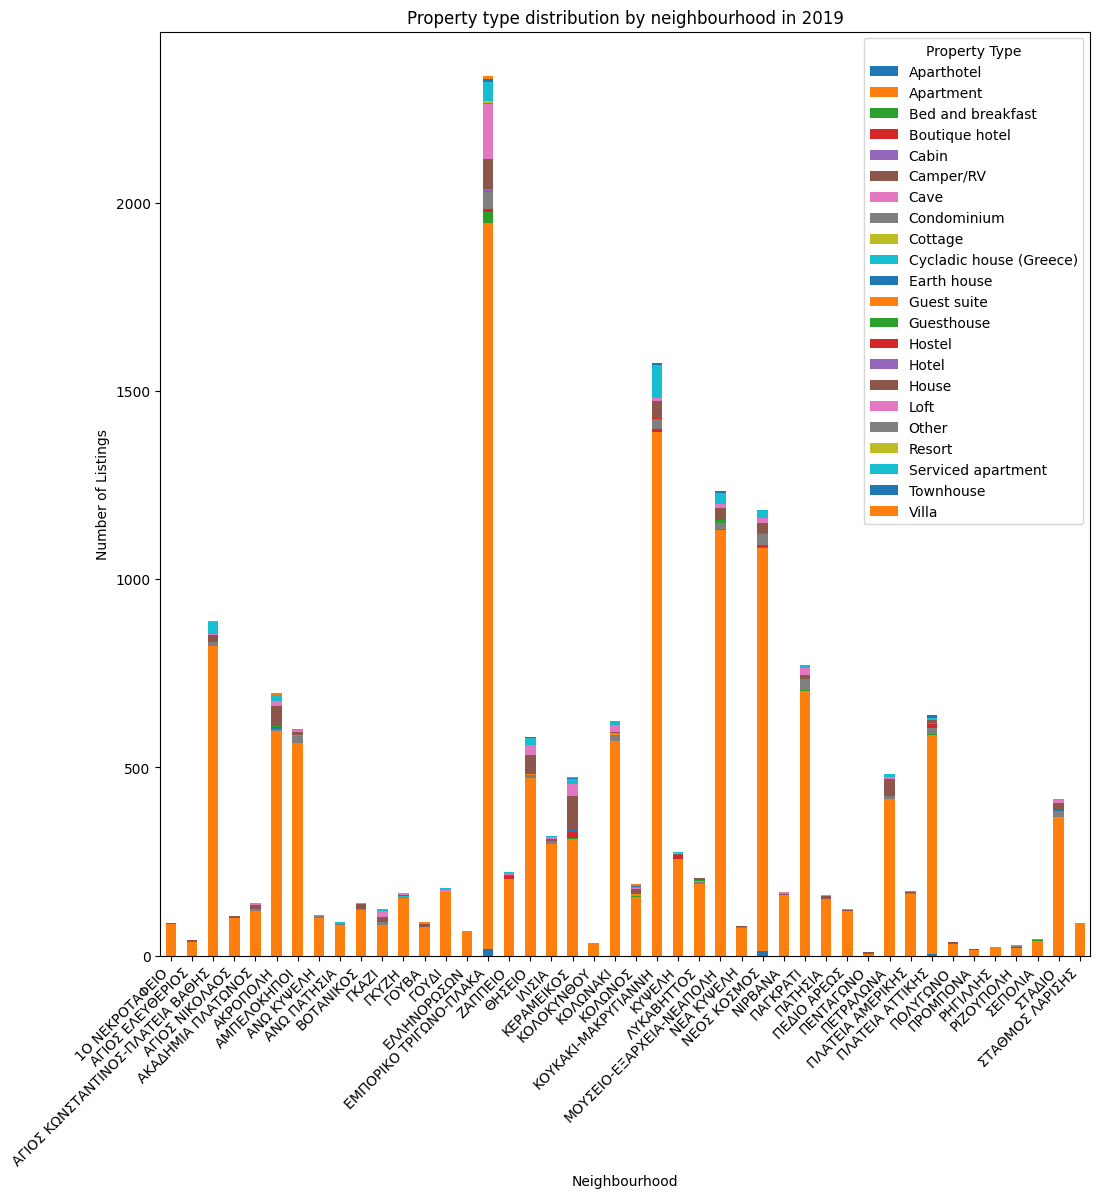

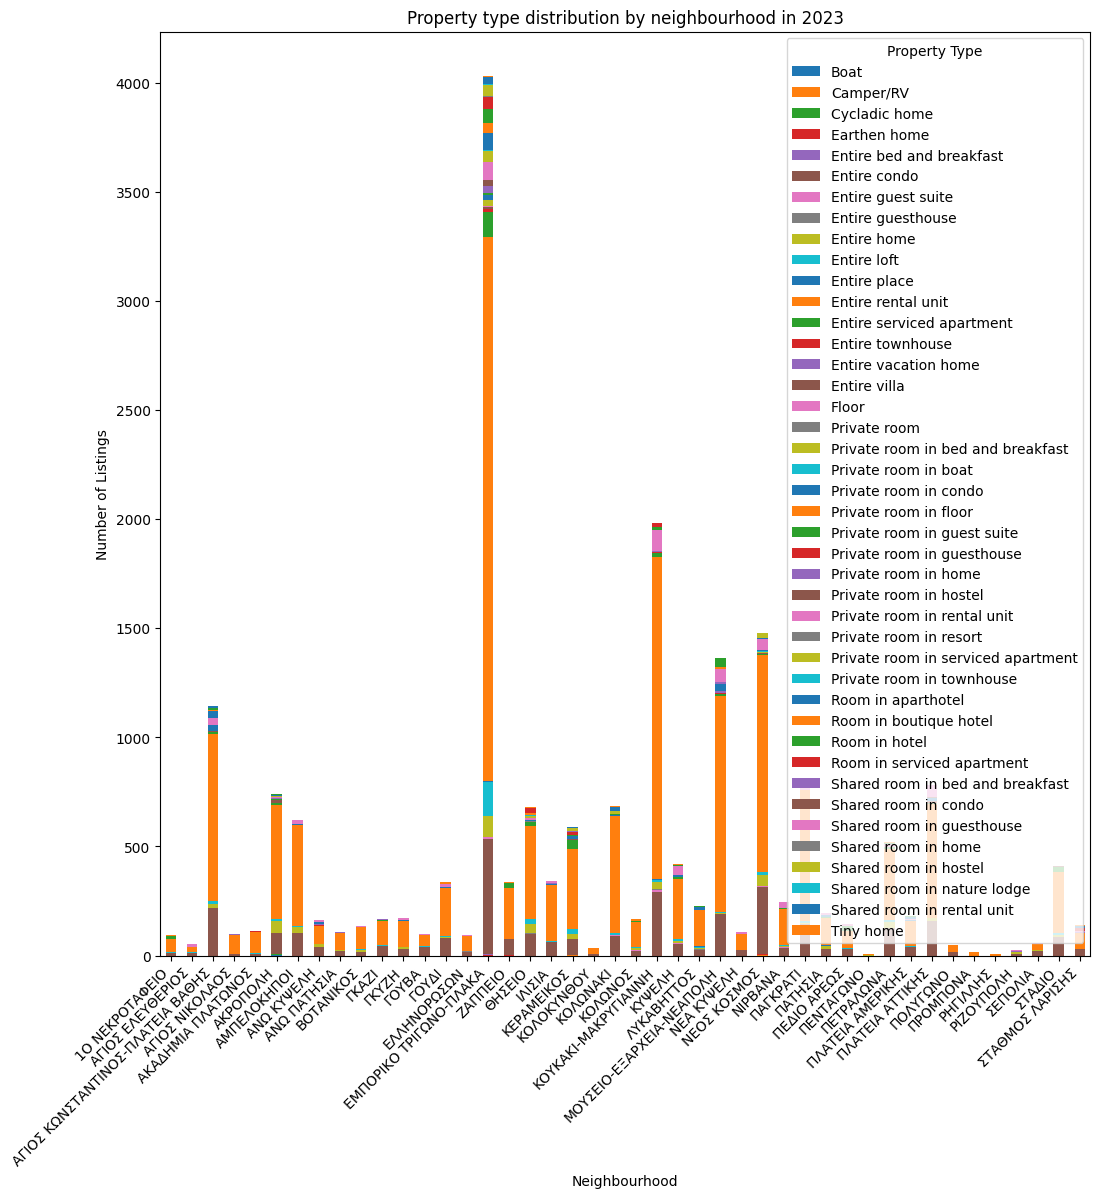

In [49]:
def query13_3(df, year):
    types = df.groupby(['neighbourhood', 'property_type']).size().unstack(fill_value=0)

    types.plot(kind='bar', stacked=True, figsize=(12,12))

    plt.xlabel('Neighbourhood')
    plt.ylabel('Number of Listings')
    plt.title(f'Property type distribution by neighbourhood in {year}')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Property Type')
    plt.show()

query13_3(m2019, 2019)
query13_3(m2023, 2023)

### **Query 14**

Who are the top 10 hosts with the most properties, and how many listings do they have?

In [50]:
def query14(df, year):
    df = df[['id', 'host_id']]
    df = df.groupby('host_id').size().reset_index(name ='num_host_listings')
    df = df.sort_values(by=['num_host_listings'], ascending=False, ignore_index=True)

    df = df.head(10)

    print(f'Top hosts in {year}')
    print(df)

query14(m2019, 2019)
print()
query14(m2023, 2023)

Top hosts in 2019
     host_id  num_host_listings
0   29927830                242
1    1418201                168
2    1621474                166
3  112527018                117
4    2089542                108
5   55670751                103
6   65714690                 98
7    1167063                 84
8   20104194                 83
9    2718115                 70

Top hosts in 2023
     host_id  num_host_listings
0   20104194                211
1  112527018                149
2     748818                140
3   29927830                133
4    2089542                130
5    1418201                124
6  113548208                112
7  129000409                 95
8   90390850                 94
9   92310506                 90


# **Part 2**
Now, we will be creating a recommendation system using the datasets.


## **Import Libraries**

In [51]:
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

nltk.download('stopwords')

spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## **Preprocessing**
At preprocessing, we apply:
- lemmatization
- removal of stopwords

**We will be using the 2019 dataset.**

In [52]:
lemm_func = lambda doc: [t.lemma_ for t in nlp(doc) if not t.is_punct and t.lemma_ != '-PRON-']

def df_preprocess(df):
    '''
    Create a copy of the dataframe and:
    1. Apply preprocessing
    2. Create a new column desc_names that contains the concatenation of name and description
    (used for the recommendation system)
    '''
    df_preproc = df.copy()
    df_preproc = df_preproc.drop_duplicates(subset='id')
    df_preproc = df_preproc.reset_index()

    # apply preprocessing
    df_preproc['description'] = df_preproc['description'].apply(lambda x: " ".join(lemm_func(x)))
    df_preproc['name']        = df_preproc['name'].apply(lambda x: " ".join(lemm_func(x)))

    # extract descriptions and titles and merge them into individual strings
    desc_l      = df_preproc['description'].to_list()
    name_l      = df_preproc['name'].to_list()
    print(len(desc_l))

    # create a new column that will store the concatenation of these two
    df_preproc['desc_name'] = [(desc_l[i] + ' ' + name_l[i]) for i in range(len(desc_l))]

    return df_preproc

df_cpy = df_preprocess(m2019)

5814


## **2.1: Create TF-IDF vectors**
The values of min_df, max_df and max_features parameters when declaring the vectorizers, were decided after experimenting. We kept in mind performance, as well as memory.

In [53]:
# declare vectorizers (unigram, bigram)
tf_unibi = tfvect(ngram_range=(1, 2), stop_words=stopwords.words(), min_df=2, max_features=4000)

# transform
tf_tr_ub = tf_unibi.fit_transform(df_cpy['desc_name'].tolist())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

In [54]:
# create the dataframes
tf_df = pd.DataFrame(tf_tr_ub.toarray(), columns=tf_unibi.get_feature_names_out(), index=df_cpy['id'])

## **2.2: Use Cosine Similarity**
In order to calculate the cosine similarity, we use the function `cosine_similarity` given by the `sklearn` library.

In [55]:
# get cosine similarity
tf_sim = cosine_similarity(tf_df)

In [56]:
def create_cosine_sim_dict(df, cosine_sim):
    '''
    Creates a dictionary that contains, for each listing, the 100 most similar listings.
    Input:
    - df: the dataframe containing the listings
    - cosine_sim: dataframe that contains the cosine similarity
    Output:
    Dictionary containing the 100 most similar listings for each listing.
    '''
    cosine_sim_dict = dict()

    # iterate over each document in the dataframe
    for idx, row in df.iterrows():

        # get the cosine similarities
        doc_similarities = cosine_sim[idx]

        # sort by similarity
        most_similar_docs = np.argsort(-doc_similarities)

        # store the IDs of the 100 most similar documents along with their similarity
        # exclude the for each listing, itself
        cosine_sim_dict[row['id']] = [(df.iloc[similar_doc_index]['id'], doc_similarities[similar_doc_index]) for similar_doc_index in most_similar_docs[1:101]]

    return cosine_sim_dict

# create the actual dictionary
cosine_sim_dict = create_cosine_sim_dict(df_cpy, tf_sim)

## **2.3: Prediction**
The `recommend` function has been implemented with the slight modification that it returns a list containing the most similar listings. Then using the `print_similarity_info` function we print those listings. We made this choice primarily for modularity reasons.

In [57]:
# print functions

def print_id(df, input_id, similarity):
    row = df[df['id'] == input_id].iloc[0]
    name = row['name']
    description = row['description']
    print("ID:         ", input_id)
    print("Recommended:", name)
    print("Description:", description)
    print(f"(score = {similarity})\n")

def print_similarity_info(similarity_info, id, df):

    row = df[df['id'] == id].iloc[0]
    name = row['name']
    msg = f"Recommending {len(similarity_info)} listings similar to '{name}'"
    print(msg)
    print(len(msg) * '-')
    for input_id, similarity in similarity_info:
        print_id(df, input_id, similarity)


In [58]:
def recommend(id, N, dict=cosine_sim_dict):
    '''
    Function that takes as input:
    - id: the id of a listing
    - N: the number of similar listings
    - dict: the dictionary that contains the most similar listings

    and returns:
    A list containing the Nth most similar listings.
    '''
    most_sim = list()
    similar_docs = dict[id]

    i = 0
    for doc_id, similarity in similar_docs:
        if i == N: break

        most_sim.append((doc_id, similarity))

        i+=1

    return most_sim

Now, let's see some examples:

In [61]:
num_of_listings = 3

print_similarity_info(recommend(10993, num_of_listings), 10993, df_cpy)

print_similarity_info(recommend(10995, num_of_listings), 10995, df_cpy)

print_similarity_info(recommend(49489, num_of_listings), 49489, df_cpy)

print_similarity_info(recommend(82239, num_of_listings), 82239, df_cpy)

print_similarity_info(recommend(916135, num_of_listings), 916135, df_cpy)

Recommending 3 listings similar to 'Studio metro cable tv wi fi etc'
--------------------------------------------------------------------
ID:          10995
Recommended: 47m2 close to metro cable tv wi fi
Description: AQA no2 be 1 bedroom apartment 47m2   -excellent locate   -close to metro station   -lovely   -very clean   with all the facility that you will need nice balcony excellent Wi Fi cable tv fully air condition etc AQA no2 be an excellent locate close to metro lovely very clean 1 bedroom apartment 45 square meter on the 2nd floor there be elevator with all the facility that you will need and a very nice balcony face the inner garden to enjoy your breakfast in the morning or relax in the evening Separated fully equip kitchen with everything you need to prepare your lunch dinner nice living room to relax and enjoy a movie or a sport event clean nice bathroom in case you be more than 2 people there be a sofa bed in the living room the studio have everything you will need -teleph

Overall, as we can see the results are very satisfactory. We are getting good recommendations with relatively high scores.

## **2.4: Collocation**

In [59]:
def print_similar(bigram):
    i = 1
    for word1, word2 in bigram:
        print(f"Pair {i}: {word1} <and> {word2}")
        i+=1

In [60]:
df_preproc = m2019.copy()
df_preproc = df_preproc.drop_duplicates(subset='id')
df_preproc = df_preproc.reset_index()

# extract descriptions and titles and merge them into individual strings
desc_l      = df_preproc['description'].to_list()
name_l      = df_preproc['name'].to_list()
print(len(desc_l))

df_preproc['desc_name'] = [(desc_l[i] + ' ' + name_l[i]) for i in range(len(desc_l))]

# extract words
words = [word for desc in df_preproc['desc_name'] for word in desc.split()]

# create bigram finder
bigram_finder = BigramCollocationFinder.from_words(words)

# find top 10 bigrams and print them
print_similar(bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 10))

5814
Pair 1: in <and> the
Pair 2: fully <and> equipped
Pair 3: living <and> room
Pair 4: The <and> apartment
Pair 5: heart <and> of
Pair 6: apartment <and> is
Pair 7: walking <and> distance
Pair 8: of <and> the
Pair 9: It <and> is
Pair 10: metro <and> station
